In [1]:
import tensorflow

In [2]:
import numpy as np

In [74]:
class Linear():
    def __init__(self, in_, out_):
        self.W = np.random.randn(in_,out_) * 0.01
        self.b = np.zeros((1,out_))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradb = None
        self.gradInput = None
    
    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output
    
    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradb = np.sum(nextgrad, axis = 0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradb]

In [93]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None
    
    def forward(self, X):
        self.output = np.maximum(X,0)
        return self.output
    
    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput [self.output<=0] = 0 
        return self.gradInput, []

In [76]:
def softmax(X):
    exp_x = np.exp(X - np.max(X, axis = 1, keepdims = True))
    return exp_x/np.sum(exp_x, axis = 1, keepdims = True)

In [77]:
class CrossEntropy():
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m),y])
        loss = np.sum(cross_entropy) /self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()
        grad = softmax(X)
        grad[range(self.m),y] -= 1
        grad /=self.m
        return grad

In [78]:
from keras.datasets import mnist
from keras.utils import np_utils

(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000,784)
print (train_features.shape)
test_features = test_features.reshape(10000,784)
print (test_features.shape)

train_features = train_features/255.0
test_features = test_features/255.0

print (train_targets.shape)
print (test_targets.shape)

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

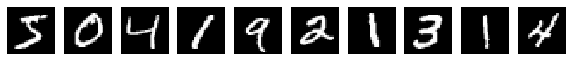

labels are  [5 0 4 1 9 2 1 3 1 4]


In [80]:
plt.figure(figsize = (10,1) )
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap = "gray")
    plt.axis("off")
plt.show()
print ("labels are ", y_train[:10])

In [87]:
class NN():
    def __init__(self, lossfunc = CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out, y)
        nextgrad = self.loss_func.backward(out, y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis = 1)

    def predict_scores(self, X):
        X = self.forward(X)
        return X
    
    def clear_grad_param(self):
        self.grads = []

In [88]:
def update_params(velocity, params, grads, learning_rate = 0.01, mu = 0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]

In [89]:
def minibatch (X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n, minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
    
    return minibatches

In [90]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu = 0.9, X_val=None, y_val = None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
        
    for i in range (epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate = learning_rate, mu = mu)
        
        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        
        y_train_pred = np.array([], dtype = "int64")
        y_val_pred = np.array([], dtype = "int64")
        y_train1 = []
        y_val1 = []        
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, :]
            y_tr = y_train[i:i + minibatch_size, ]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr) )
        
        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, :]
            y_va = y_val[i:i + minibatch_size, ]
            y_val1 = np.append(y_val1, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va) )
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_train1, y_train_pred)
        
        mean_train_loss = sum(loss_batch)/float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch)/float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print (mean_train_loss)
        print (mean_val_loss)
    return net

In [91]:
def check_accuracy(y_true, y_pred):
    return (np.mean(y_true==y_pred))

In [94]:
from random import shuffle

input_dim = X_train.shape[1]

iterations = 10
learning_rate = 0.1
hidden_nodes = 32
output_nodes = 10

nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn =train(nn, X_train, y_train, minibatch_size=200, epoch = 10, learning_rate= learning_rate, X_val = X_val, y_val = y_val)

0.4927763726985172
0.2458195475383681
0.18457461907675027
0.18011661158148765
0.13803881334084708
0.14936240628967484
0.11452662911961763
0.13189732538172041
0.1004949593539651
0.11743195071970629
0.0904879027008283
0.10644472775527002
0.08250660714563252
0.10272161981652532
0.07598187254962276
0.09353892114219058
0.07114469643902745
0.09723847258224938
0.06781262831815983
0.10749690492632383


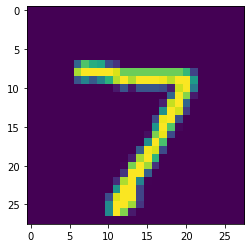

In [95]:
plt.imshow(X_val[0].reshape(28,28))

In [96]:
prediction = nn.predict_scores(X_val[0])[0]

In [97]:
prediction

array([ -3.43739463,  -3.31425712,   5.68262486,   6.95561397,
        -9.00817415,   0.94006677, -16.39920135,  15.36538548,
         1.38587014,   2.2015175 ])

In [98]:
nn.predict(X_val[0])

array([7], dtype=int64)